In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests 
import random

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!conda install -c conda-forge geocoder --yes
import geocoder 
import os

from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium 
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')
print('Folium installed')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [131]:
def geo_location(address): 'New york city, NY'
    # get geo location of address
geolocator = Nominatim(user_agent="ny_explorer")
locatidn = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
return latitude,longitude

(40.7127281, -74.0060152)

In [139]:
CLIENT_ID = 'EGPABFKVZ5JWWHVCG2IGWTDXIUU3HT2K24PQ2XKMHB4KMO0M'
CLIENT_SECRET = 'KL2RZIPE4H02ADKNO5UHPT4GGVG4QKJ2IO2UL1HZLMUMM3LQ'
VERSION = '20200621'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: EGPABFKVZ5JWWHVCG2IGWTDXIUU3HT2K24PQ2XKMHB4KMO0M
CLIENT_SECRET: KL2RZIPE4H02ADKNO5UHPT4GGVG4QKJ2IO2UL1HZLMUMM3LQ


In [140]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [141]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [142]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

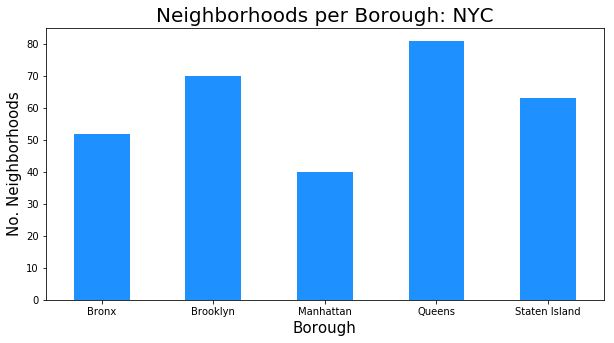

In [143]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Lets analyze further and see how many lebanese restaurants there are in each neighborhood and burough and graph the results.

In [169]:
# queens has most neighborhoods
# prepare neighborhood list that contains lebanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Lebanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Lebanese_resturants=venues[venues['Category']=='Lebanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Lebanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(Lebanese_resturants)))
    print(row)
    for resturant_detail in Lebanese_resturants.values.tolist():
        id, name , category=resturant_detail
        Lebanese_rest_ny = Lebanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Lebanese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Lebanese Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Lebanese Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Lebanese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Lebanese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Lebanese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Lebanese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Lebanese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Lebanese Resturants in Norwood, Bronx:0
['

In [170]:
Lebanese_rest_ny.to_csv('Lebanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [171]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Manhattan,Greenwich Village,550af1d0498e5c0bd04229e6,Manousheh


In [172]:
Lebanese_rest_ny.shape

(1, 4)

as we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number of lebanese restaurants. Additionally, we will now see how many restaurants the top 6 neighborhoods have.

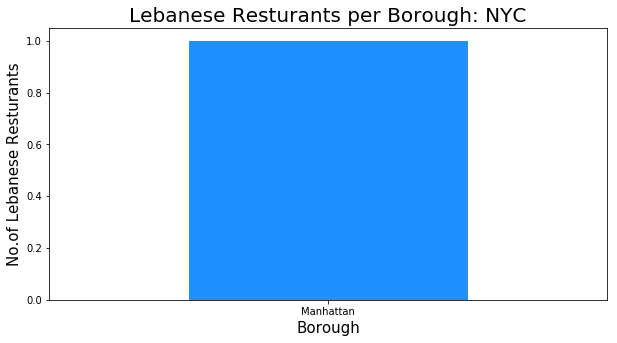

In [173]:
Lebanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Lebanese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Lebanese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

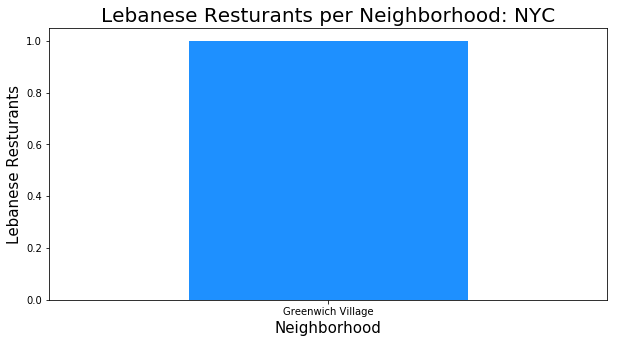

In [174]:
NOofNeigh = 6 # top number for graphing all the same past 6
Lebanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Lebanese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Lebanese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [175]:
Lebanese_rest_ny[italian_rest_ny['Neighborhood']=='Greenwich Village']

,Borough,Neighborhood,ID,Name
0,Manhattan,Greenwich Village,550af1d0498e5c0bd04229e6,Manousheh


In [176]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Lebanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in Lebanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Lebanese_rest_ny),')','processed')
    Lebanese_rest_stats_ny = Lebanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
Lebanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5eefdd01a2e538001b4e1b68'}, 'response': {'venue': {'id': '550af1d0498e5c0bd04229e6', 'name': 'Manousheh', 'contact': {'phone': '3479715778', 'formattedPhone': '(347) 971-5778', 'twitter': 'manoushehnyc', 'facebook': '1379440182285854', 'facebookUsername': 'ManoushehNYC', 'facebookName': 'Manousheh NYC'}, 'location': {'address': '193 Bleecker St', 'crossStreet': 'btwn MacDougal & Minetta St', 'lat': 40.72937268195377, 'lng': -74.00135010480881, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72937268195377, 'lng': -74.00135010480881}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['193 Bleecker St (btwn MacDougal & Minetta St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/manousheh/550af1d0498e5c0bd04229e6', 'categories': [{'id': '58daa1558bbb0b01f18ec1cd', 'name': 'Lebanese Restaurant', 'pluralName': 'Lebanese Restaurants', 'shortName': 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Greenwich Village,550af1d0498e5c0bd04229e6,Manousheh,262,8.9,65


In [177]:
Lebanese_rest_stats_ny.to_csv('Lebanese_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [178]:
Lebanese_rest_stats_ny.shape

(1, 7)

In [179]:
Lebanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
Borough         1 non-null object
Neighborhood    1 non-null object
ID              1 non-null object
Name            1 non-null object
Likes           1 non-null object
Rating          1 non-null float64
Tips            1 non-null object
dtypes: float64(1), object(6)
memory usage: 136.0+ bytes


In [180]:
Lebanese_rest_stats_ny['Likes']=Lebanese_rest_stats_ny['Likes'].astype('float64')
Lebanese_rest_stats_ny['Tips']=Lebanese_rest_stats_ny['Tips'].astype('float64')
Lebanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
Borough         1 non-null object
Neighborhood    1 non-null object
ID              1 non-null object
Name            1 non-null object
Likes           1 non-null float64
Rating          1 non-null float64
Tips            1 non-null float64
dtypes: float64(3), object(4)
memory usage: 136.0+ bytes


In [181]:
Lebanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,1.0,1.0,1.0
mean,262.0,8.9,65.0
std,NaN,NaN,NaN
min,262.0,8.9,65.0
25%,262.0,8.9,65.0
50%,262.0,8.9,65.0
75%,262.0,8.9,65.0
max,262.0,8.9,65.0


In [182]:
# Resturant with maximum Likes
Lebanese_rest_stats_ny.iloc[Lebanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              550af1d0498e5c0bd04229e6
Name                           Manousheh
Likes                                262
Rating                               8.9
Tips                                  65
Name: 0, dtype: object

In [183]:
# Resturant with maximum Ratings
Lebanese_rest_stats_ny.iloc[Lebanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              550af1d0498e5c0bd04229e6
Name                           Manousheh
Likes                                262
Rating                               8.9
Tips                                  65
Name: 0, dtype: object

In [184]:
# Resturant with maximum Tips
Lebanese_rest_stats_ny.iloc[Lebanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              550af1d0498e5c0bd04229e6
Name                           Manousheh
Likes                                262
Rating                               8.9
Tips                                  65
Name: 0, dtype: object

In [185]:
ny_neighborhood_stats=Lebanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Greenwich Village,8.9


In [186]:
ny_borough_stats=Lebanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Manhattan,8.9


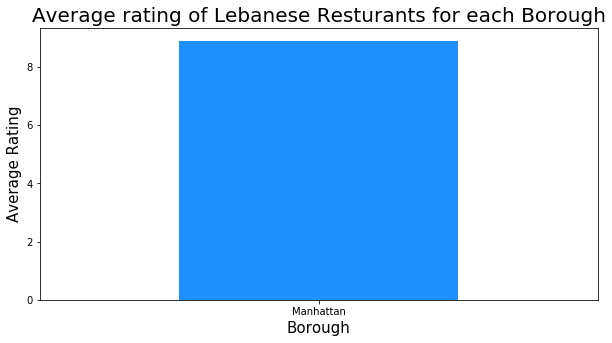

In [187]:
Lebanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Lebanese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods

In [188]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Greenwich Village,8.9


In [189]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Greenwich Village,40.726933,-73.999914,8.9


In [192]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [193]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)